## Imports and Constants

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import cv2
import time

WIDTH = 320
HEIGHT = 240

IMAGE_W = 1920
IMAGE_H = 1080
WINDOW_W = 928
WINDOW_H = 696
WINDOW_X = (IMAGE_W - WINDOW_W) // 2
WINDOW_Y = 0
MAX_D = 101
ADDED_D = 4

MARGIN = 5

ROOT_FOLDER = "D:/tensorflow-depth-estimation"

IMAGES = ["./input/frame_00955.jpg",
          "./input/frame_00319.jpg",
          "./input/frame_00942.jpg",
          "./input/frame_01250.jpg"]


MODEL_NAME = f"{ROOT_FOLDER}/model_kitti_unet_1709064377.keras"

%run ../utils/datasets.ipynb

model = tf.keras.models.load_model(MODEL_NAME, compile=False) # only for prediction

## Helper Functions

In [2]:
def draw_distances(image, prediction, points):
    depth3 = image.copy()
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    font_scale = 0.5
    color = (255, 0, 0)
    thickness = 1
    
    find = points.copy()
    
    for h in range(HEIGHT - 1, 0, -1):
        for w in range(WIDTH):
            if find[h, w] > 128:
                dist = ADDED_D + prediction[h, w, 0] * MAX_D
                text = f"{dist:.2f} m"
                text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
                text_pos = w - text_size[0] // 2, h
                rectangle = np.ones((text_size[1] + 2, text_size[0], 3), np.uint8) * 255
                alpha = 0.5
                try:
                    depth3[text_pos[1] - text_size[1] // 2: text_pos[1] + text_size[1] // 2 + 2, text_pos[0] : text_pos[0] + text_size[0]] = \
                        cv2.addWeighted(depth3[text_pos[1] - text_size[1] // 2: text_pos[1] + text_size[1] // 2 + 2, text_pos[0] : text_pos[0] + text_size[0]],
                                        alpha, rectangle, 1 - alpha, 0)
                    depth3 = cv2.putText(depth3, text,
                                         (text_pos[0], text_pos[1] + text_size[1] // 2), font,
                                         font_scale, color, thickness, cv2.LINE_AA)
                    t_w = text_size[0]
                    t_h = text_size[1]
                    depth3[h, w] = (0,0,255)
                    depth3 = cv2.line(depth3, ((WINDOW_X + WINDOW_W // 2 - 788) // 2, 726 // 2), (w, h), (0, 0, 255))
                    find[max(0, h - t_h - 1) : min(h + t_h + 1, HEIGHT - 1), max(0, w - t_w - 1) : min(w + t_w + 1, WIDTH - 1)] = 0
                except:
                    pass
    return depth3

In [3]:
def clear_lanes(points):
    points = points.copy()

    for h in range(HEIGHT):
        for w in range(WIDTH):
            if h < 60 or h > 200 or w < 5 or w > 314:
                points[h, w] = 0
            if h < 220 and (w / (h - 220) > -0.9 or (WIDTH - w) / (h - 220) > -0.5):
                points[h, w] = 0

    return points

In [4]:
def get_template():
    template = np.zeros((7, 13), np.uint8)
    template[0:3,:] = 64
    template[3,:] = 128
    template[4:,:] = 192
    return template

## Figure 1. U-Net Architecture

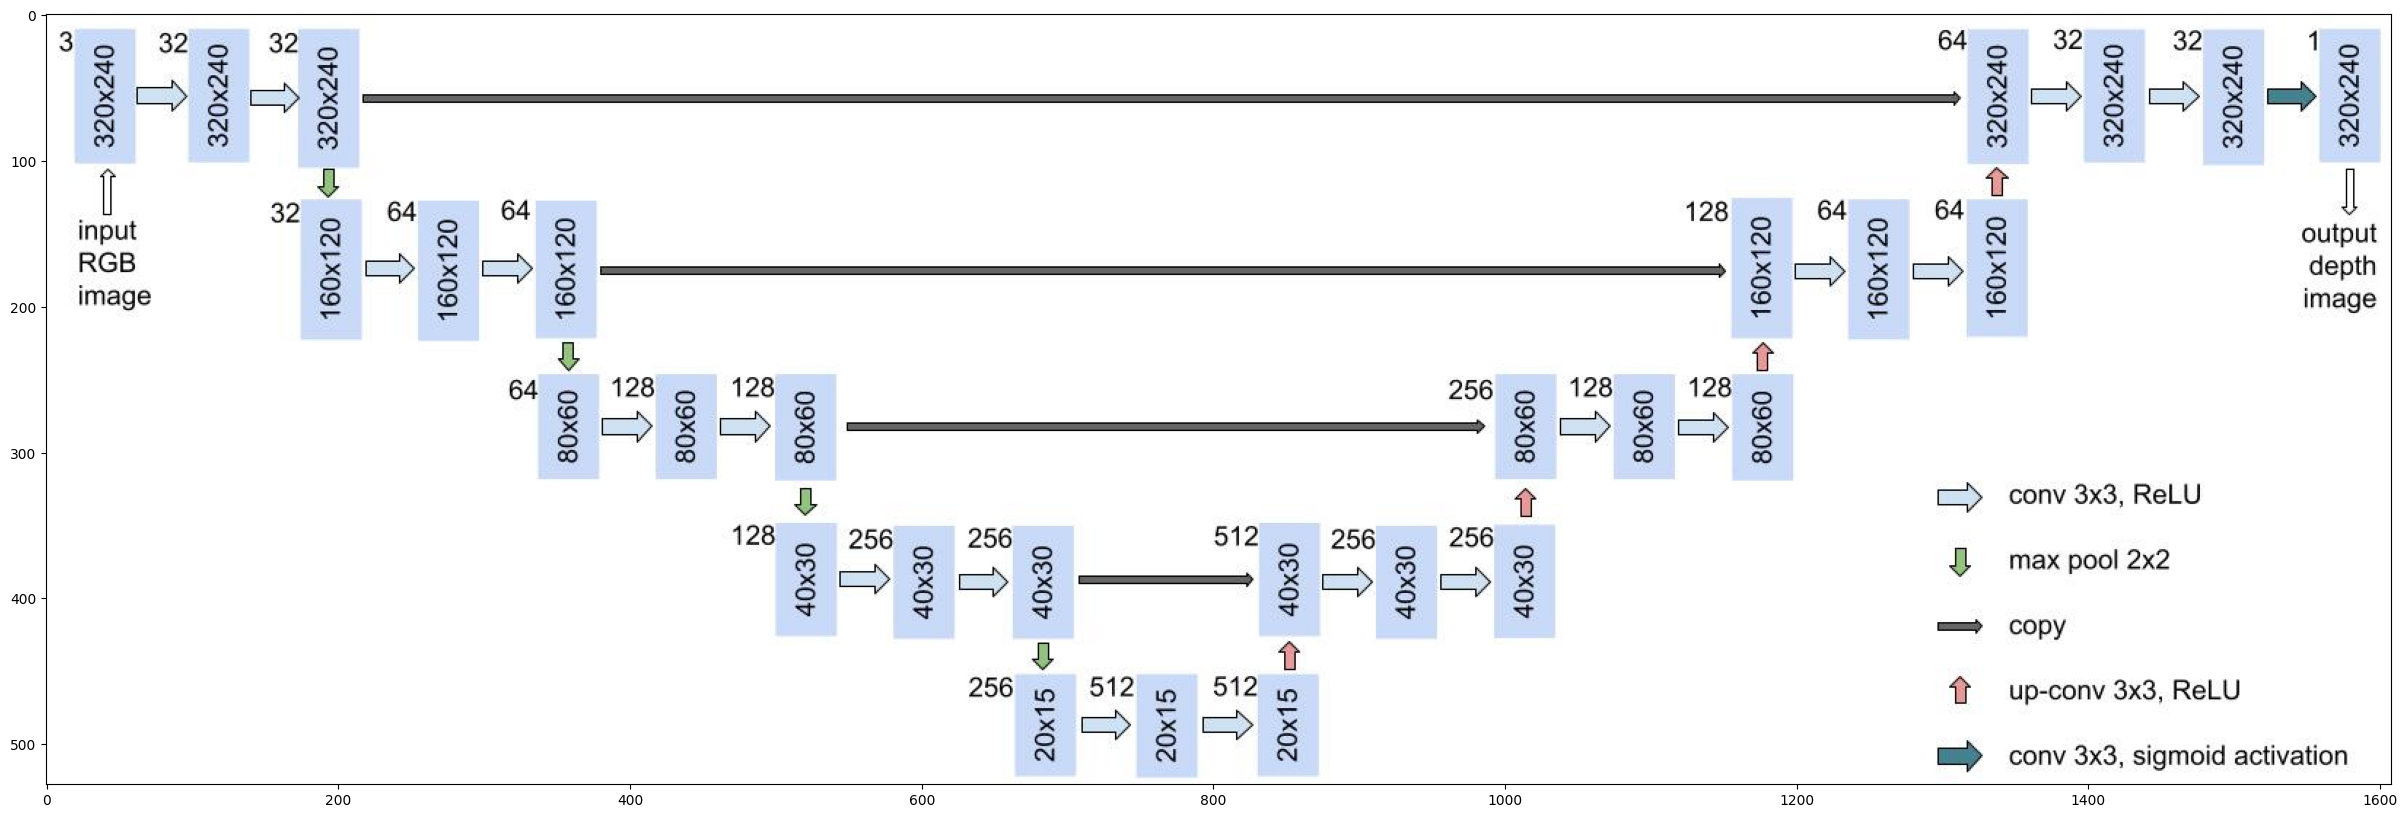

In [5]:
image = cv2.imread("./input/u-net.jpg")

cv2.imwrite("fig1.jpg", image)

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Figure 2. KITTI Dataset Preparation

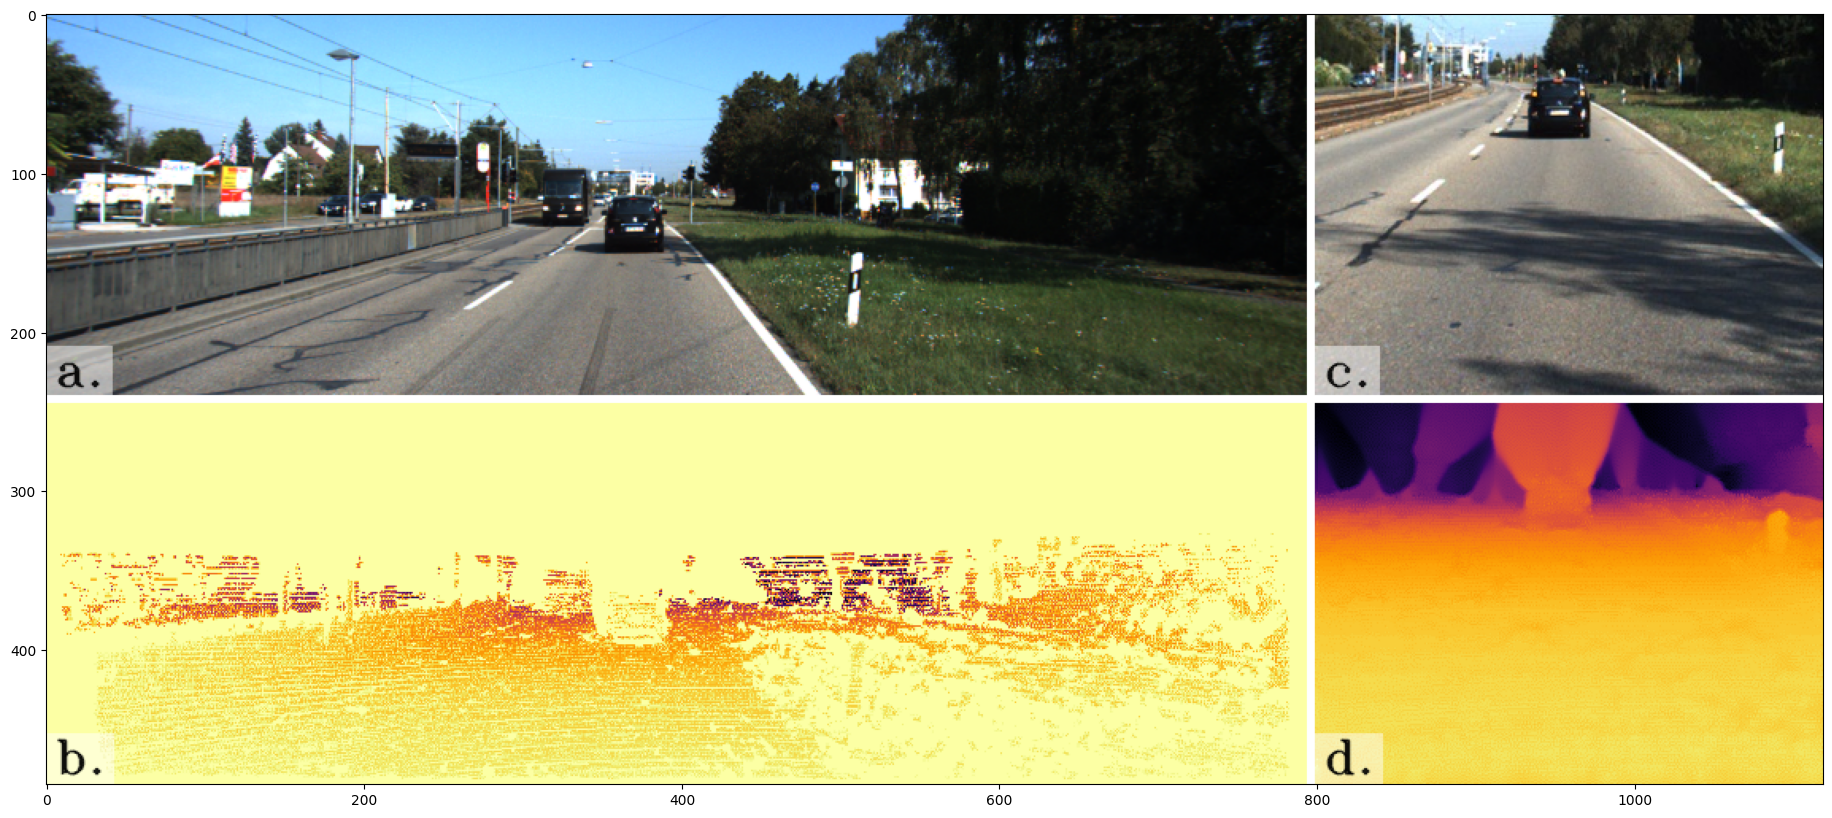

In [6]:
# KITTI: 1242 x 375
kitti_resized_w = int(1242 / 375 * HEIGHT)

rgb = cv2.resize(cv2.imread("./input/kitti/rgb.png"), (kitti_resized_w, HEIGHT)) 
lidar = cv2.resize(cv2.imread("./input/kitti/lidar.png"), (kitti_resized_w, HEIGHT))
lidar = lidar / np.max(lidar) * 255
lidar = cv2.applyColorMap((255 - lidar).astype(np.uint8), cv2.COLORMAP_INFERNO)

cropped = cv2.imread("./input/kitti/rgb_cropped.jpg")
lidar_cropped_inpainted = cv2.imread("./input/kitti/lidar_cropped_inpainted.png")
lidar_cropped_inpainted = lidar_cropped_inpainted / np.max(lidar_cropped_inpainted) * 255
lidar_cropped_inpainted = cv2.applyColorMap((255 - lidar_cropped_inpainted).astype(np.uint8), cv2.COLORMAP_INFERNO)

fig = (np.ones((HEIGHT * 2 + MARGIN, WIDTH + MARGIN + kitti_resized_w, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :kitti_resized_w] = rgb

fig[HEIGHT + MARGIN:, :kitti_resized_w] = lidar

fig[:HEIGHT, kitti_resized_w + MARGIN:] = cropped

fig[HEIGHT + MARGIN:, kitti_resized_w + MARGIN:] = lidar_cropped_inpainted

font = cv2.FONT_HERSHEY_TRIPLEX
font_scale = 1
color = (0, 0, 0)
thickness = 1
alpha = 0.5

labels = [("a.", 0, HEIGHT),
          ("b.", 0, 2 * HEIGHT + MARGIN - 1),
          ("c.", kitti_resized_w + MARGIN, HEIGHT),
          ("d.", kitti_resized_w + MARGIN, 2 * HEIGHT + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig2.jpg", fig)

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

## Figure 3. Color Camera Input

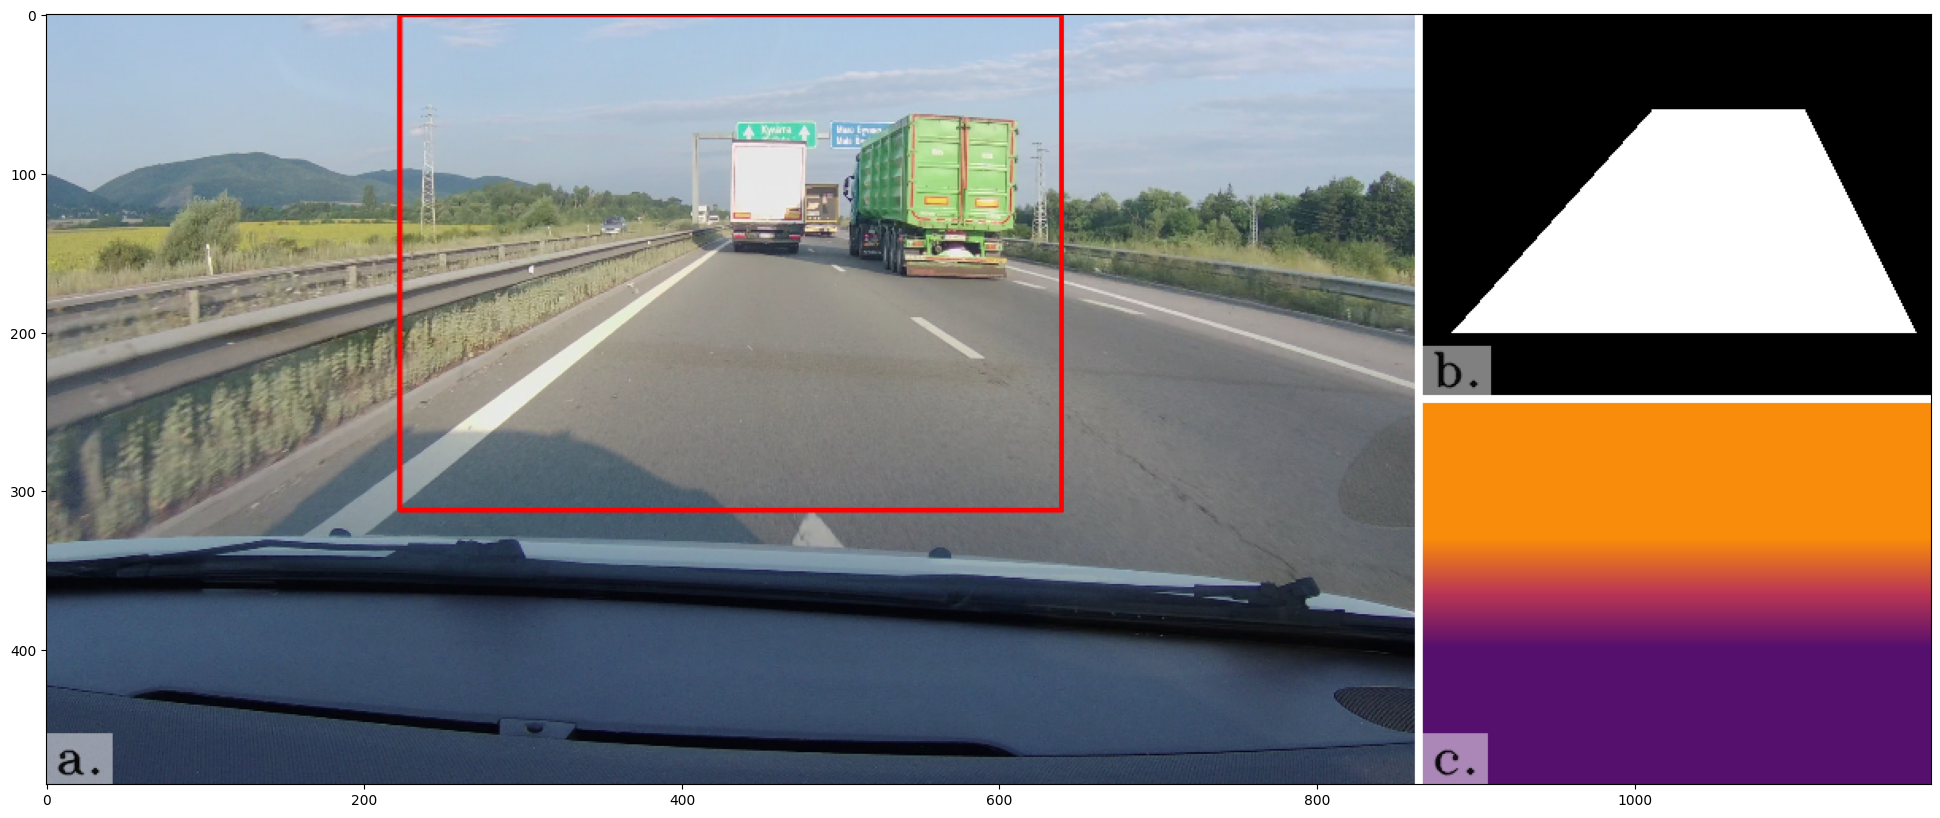

In [7]:
image = cv2.imread(IMAGES[1])
image = cv2.rectangle(image, (WINDOW_X, WINDOW_Y), (WINDOW_X + WINDOW_W, WINDOW_Y + WINDOW_H),
                      (0, 0, 255), 5)
#cv2.imwrite("fig1.jpg", image)


depth = np.ones((HEIGHT, WIDTH, 3), np.uint8) * 255
depth = clear_lanes(depth)

template = get_template()
template = cv2.applyColorMap(255 - template, cv2.COLORMAP_INFERNO)

w, h = 1920 * (HEIGHT * 2 + MARGIN) // 1080, HEIGHT * 2 + MARGIN
image = cv2.resize(image, (w, h))
depth = cv2.resize(depth, (WIDTH, HEIGHT))
template = cv2.resize(template, (WIDTH, HEIGHT))

fig = np.ones((HEIGHT * 2 + MARGIN, WIDTH + MARGIN + w, 3), np.uint8) * 255
fig[:h, :w] = image
fig[:HEIGHT, w + MARGIN:] = depth
fig[HEIGHT + MARGIN:, w + MARGIN:] = template

labels = [("a.", 0, HEIGHT * 2 + MARGIN - 1),
          ("b.", w + MARGIN, HEIGHT),
          ("c.", w + MARGIN, HEIGHT * 2 + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig3.jpg", fig)

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

## Figure 4. Depth Estimation

./input/frame_00955.jpg
./input/frame_00319.jpg
./input/frame_00942.jpg
./input/frame_01250.jpg
4/4 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

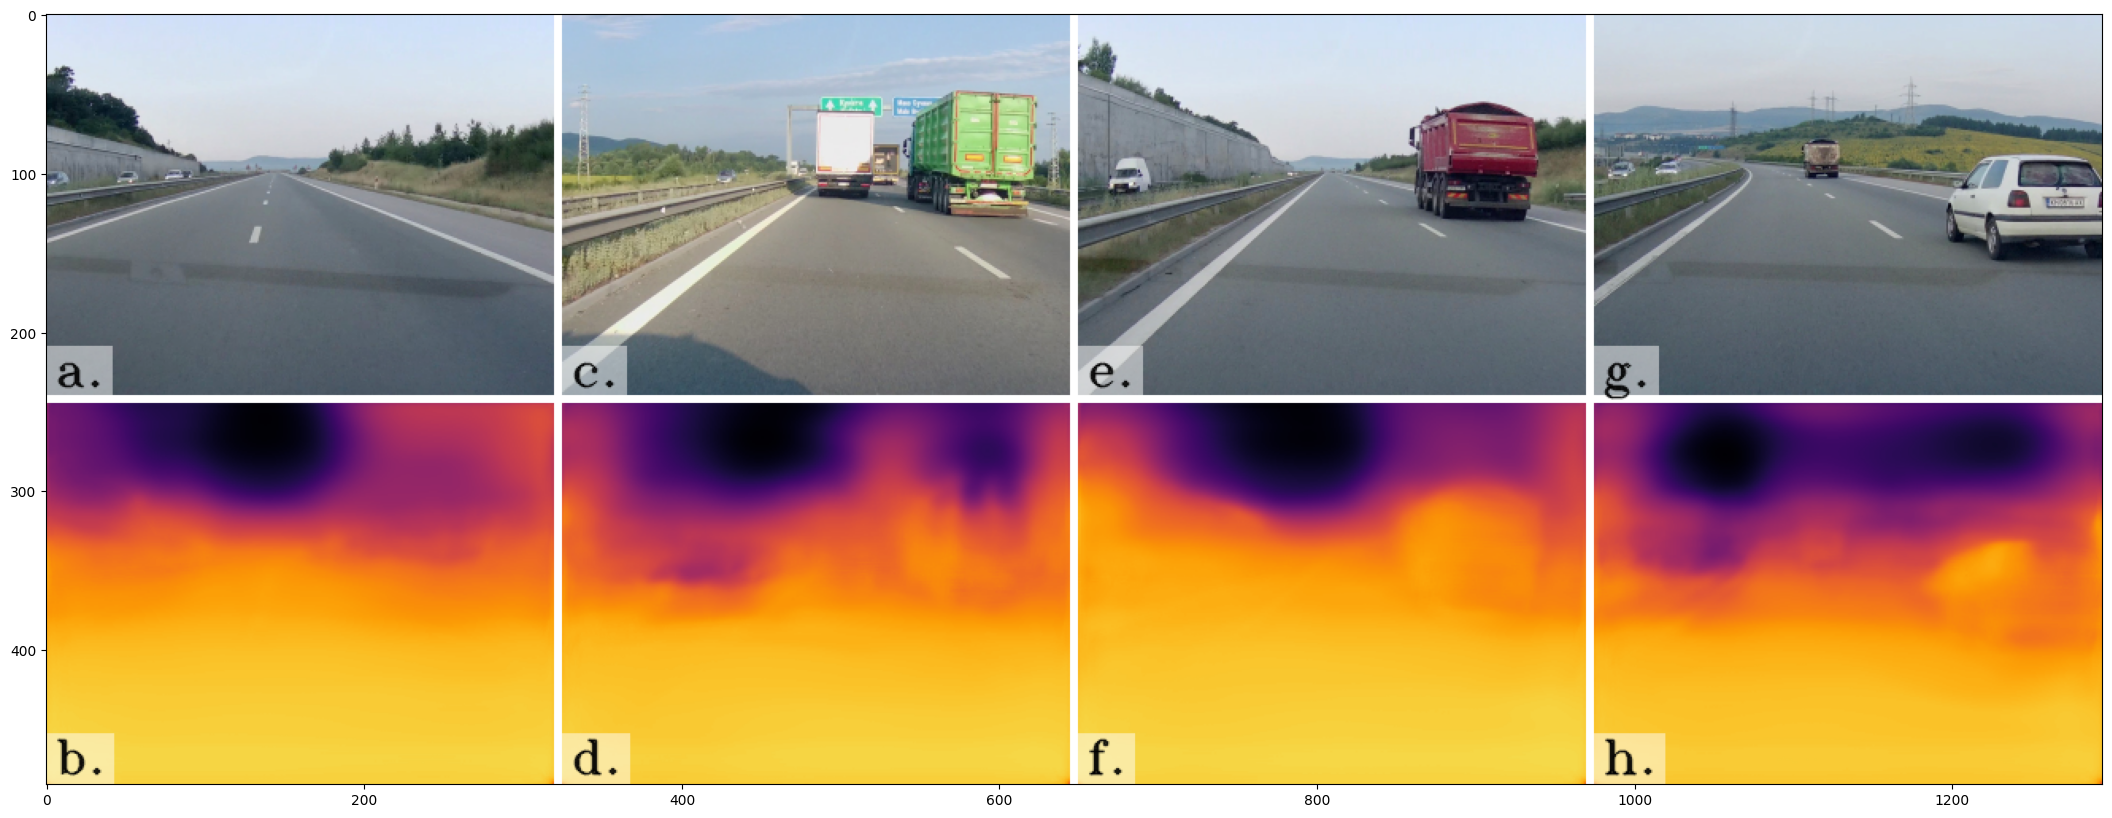

In [8]:
depths = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))
images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

x_test = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

for i in range(len(IMAGES)):
    print(IMAGES[i])
    image = cv2.imread(IMAGES[i])
    image2 = image[:WINDOW_H, (IMAGE_W - WINDOW_W) // 2 : (IMAGE_W + WINDOW_W) // 2, :]
    cv2.imwrite(f"{ROOT_FOLDER}/tmp.jpg", image2)
    x_test[i, ] = preprocess_image(f"{ROOT_FOLDER}/tmp.jpg", HEIGHT, WIDTH, depth=False, horizontal_flip=False)

predictions = model.predict(x_test, batch_size=1)

for k in range(len(IMAGES)):
    img1 = x_test[k, ].copy()
    images[k] = (img1 * 255).astype(np.uint8)
    depth = ADDED_D + predictions[k] * MAX_D
    depth = (depth / np.max(depth) * 255).astype(np.uint8)
    depths[k] =  cv2.applyColorMap(255 - depth, cv2.COLORMAP_INFERNO)
    # plt.figure(i)
    # plt.subplot(1, 2, 1)
    # plt.axis("off")
    # img1 = x_test[k, ].copy()
    # img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    # plt.imshow(img1)

    # plt.subplot(1, 2, 2)
    # plt.axis("off")
    # plt.imshow(predictions[k], cmap=plt.get_cmap('inferno_r'))

fig = (np.ones((HEIGHT * 2 + MARGIN, WIDTH * 4 + 3 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[0]
fig[HEIGHT + MARGIN:, :WIDTH] = depths[0]
fig[:HEIGHT, WIDTH + MARGIN : 2 * WIDTH + MARGIN] = images[1]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN : 2 * WIDTH + MARGIN] = depths[1]
fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN : 3 * WIDTH + 2 * MARGIN] = images[2]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN : 3 * WIDTH + 2 * MARGIN] = depths[2]
fig[:HEIGHT, 3 * WIDTH + 3 * MARGIN:] = images[3]
fig[HEIGHT + MARGIN:, 3 * WIDTH + 3 * MARGIN:] = depths[3]

labels = [("a.", 0, HEIGHT),
          ("b.", 0, 2 * HEIGHT + MARGIN - 1),
          ("c.", WIDTH + MARGIN, HEIGHT),
          ("d.", WIDTH + MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("e.", 2 * WIDTH + 2 * MARGIN, HEIGHT),
          ("f.", 2 * WIDTH + 2 * MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("g.", 3 * WIDTH + 3 * MARGIN, HEIGHT),
          ("h.", 3 * WIDTH + 3 * MARGIN, 2 * HEIGHT + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig4.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

## Figure 5. Algorithm 1. Empty Road Difference

Image 1 processing time: 10 ms
Image 2 processing time: 20 ms
Image 3 processing time: 19 ms


<Figure size 640x480 with 0 Axes>

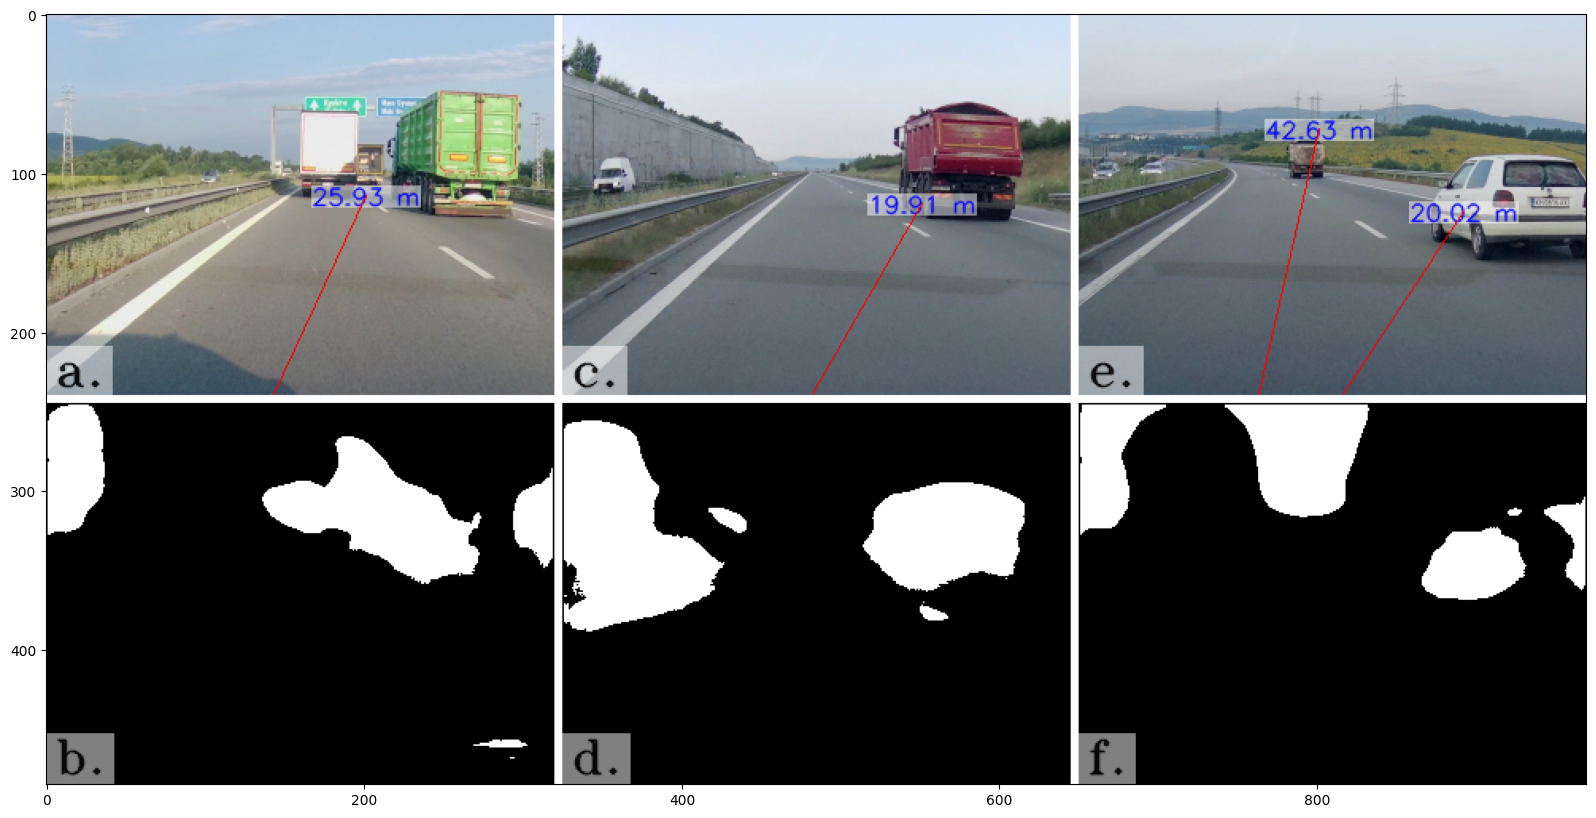

In [9]:
depths = np.empty((len(IMAGES), HEIGHT, WIDTH))
images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

empty_road_prediction = predictions[0].copy()

for k in range(1, len(IMAGES)):
    start = time.time()
    
    diff = empty_road_prediction[:,:,0] / predictions[k,:,:,0]
    
    diff = diff > 1.25
        
    depth = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)

    depth[diff] = 255
    
    # for h in range(HEIGHT):
    #     for w in range(WIDTH):
    #         if diff[h, w]:
    #             depth[h, w] = 255
    
    ret1, lab = cv2.connectedComponents(clear_lanes(depth))
    
    points = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    
    for i in range(1, ret1):
        component = np.zeros((HEIGHT, WIDTH), np.uint8)
        component[lab == i] = 255
        if np.count_nonzero(component) > 120:
            rect = cv2.boundingRect(component)
            points[rect[1] + rect[3], rect[0] + rect[2] // 2] = 255
            # print(rect[1] + rect[3], rect[0] + rect[2] // 2)

    
    print(f"Image {k} processing time: {int((time.time() - start) * 1000)} ms")
    
    img1 = x_test[k, ].copy()
    img1 = (img1 * 255).astype(np.uint8)
    img1 = draw_distances(img1, predictions[k], points)
    
    # plt.figure(k)
    # plt.figure(figsize=(40,10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(depth, 'gray')
    # plt.subplot(1, 3, 2)
    # plt.imshow(points, 'gray')
    # plt.subplot(1, 3, 3)
    # plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    depths[k,1:HEIGHT-1,1:WIDTH-1] = depth[1:HEIGHT-1,1:WIDTH-1]
    images[k,] = img1

fig = (np.ones((HEIGHT * 2 + MARGIN, WIDTH * 3 + 2 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[1]
fig[HEIGHT + MARGIN:, :WIDTH, 0] = depths[1]
fig[HEIGHT + MARGIN:, :WIDTH, 1] = depths[1]
fig[HEIGHT + MARGIN:, :WIDTH, 2] = depths[1]

fig[:HEIGHT, WIDTH + MARGIN:2 * WIDTH + MARGIN] = images[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 0] = depths[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 1] = depths[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 2] = depths[2]

fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN:] = images[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 0] = depths[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 1] = depths[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 2] = depths[3]

labels = [("a.", 0, HEIGHT),
          ("b.", 0, 2 * HEIGHT + MARGIN - 1),
          ("c.", WIDTH + MARGIN, HEIGHT),
          ("d.", WIDTH + MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("e.", 2 * WIDTH + 2 * MARGIN, HEIGHT),
          ("f.", 2 * WIDTH + 2 * MARGIN, 2 * HEIGHT + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig5.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

## Figure 6. Algortihm 2. Template Matching

Image 1 processing time: 30 ms
Image 2 processing time: 20 ms
Image 3 processing time: 40 ms


<Figure size 640x480 with 0 Axes>

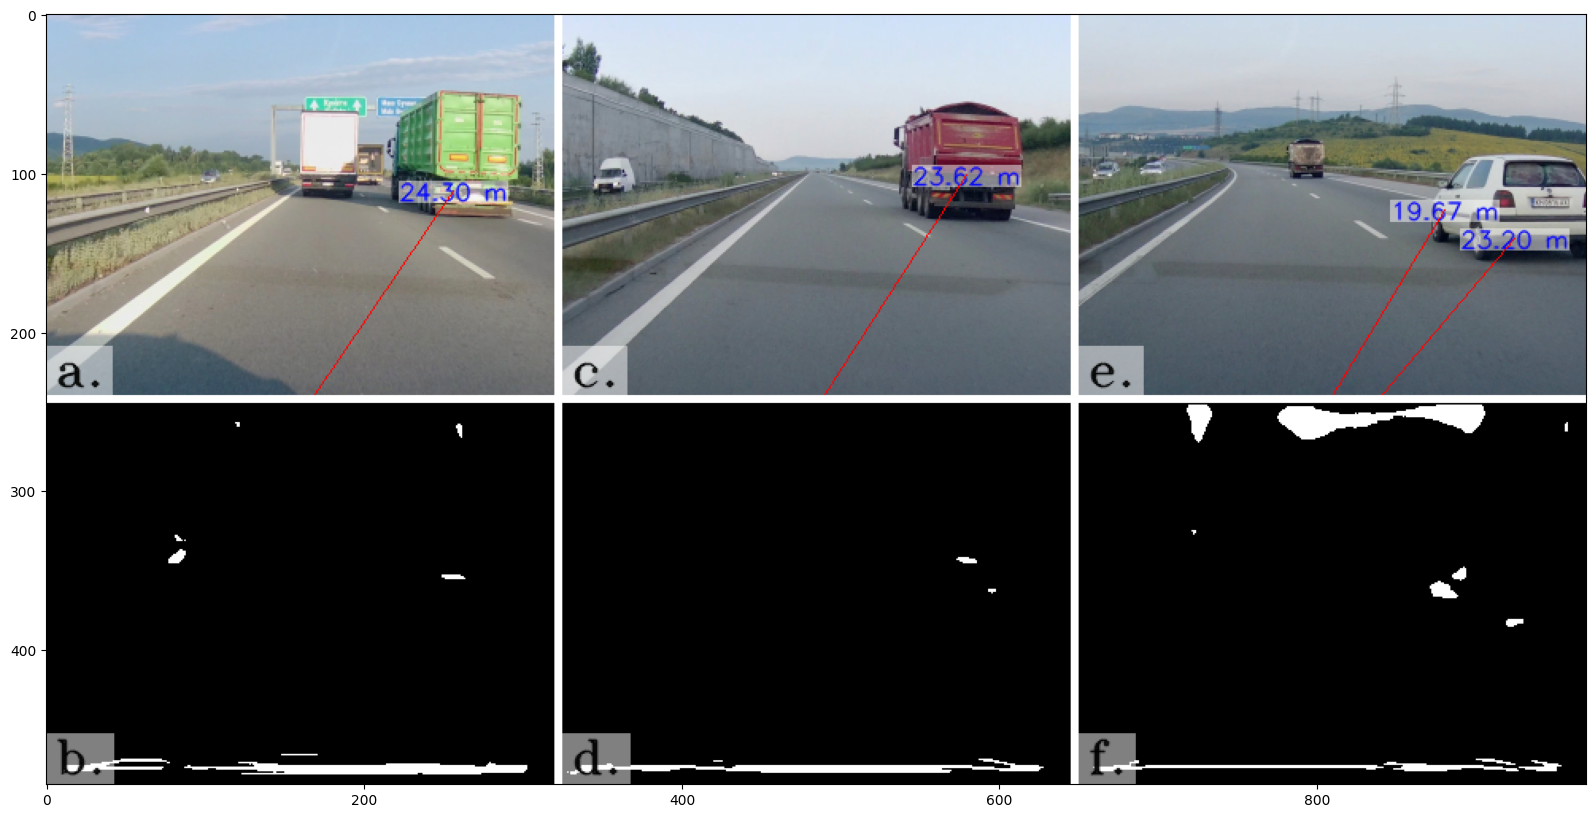

In [10]:
depths = np.empty((len(IMAGES), HEIGHT, WIDTH))
images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

template = get_template()

for k in range(1, len(IMAGES)):
    start = time.time()
    normalized = ((predictions[k] / np.max(predictions[k])) * 255).astype(np.uint8)
    
    # Perform template matching
    result = cv2.matchTemplate(normalized, template, cv2.TM_CCOEFF_NORMED)
    
    # Set a threshold for the match score
    threshold = 0.8
    
    # Locate where the template matches exceed the threshold
    locations = np.where(result >= threshold)
    
    depth = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    
    # Iterate through the matched locations
    for pt in zip(*locations[::-1]):
        # Extract the coordinates of the matched region
        x, y = pt
        
        # Compute the width and height of the template
        h, w = template.shape
        
        # Extract the depth values from the matched region
        depth_values = normalized[y:y+h, x:x+w]
        
        # Compute the median depth value
        median_depth = np.median(depth_values)
        
        # Print the coordinates of the matched region and the median depth value
        # print(f"Object detected at ({x}, {y}) with width {w}, height {h} and median depth {median_depth}")
    
        depth[y, x] = 255
        # Optionally, you can draw rectangles around the matched regions on the original depth image
        cv2.rectangle(normalized, (x, y), (x+w, y+h), (0, 255, 0), 2)

    ret1, lab = cv2.connectedComponents(clear_lanes(depth))
    
    points = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    
    for i in range(1, ret1):
        component = np.zeros((HEIGHT, WIDTH), np.uint8)
        component[lab == i] = 255
        if np.count_nonzero(component) > 30:
            rect = cv2.boundingRect(component)
            points[rect[1] + rect[3], rect[0] + rect[2] // 2] = 255
            # print(rect[1] + rect[3], rect[0] + rect[2] // 2)

    print(f"Image {k} processing time: {int((time.time() - start) * 1000)} ms")
    # Display the results

    img1 = x_test[k, ].copy()
    img1 = (img1 * 255).astype(np.uint8)
    img1 = draw_distances(img1, predictions[k], points)
    
    # plt.figure(k)
    # plt.figure(figsize=(40,10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(depth, 'gray')
    
    # plt.subplot(1, 3, 2)
    # plt.imshow(points, 'gray')
    # plt.subplot(1, 3, 3)
    # plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    depths[k,1:HEIGHT-1,1:WIDTH-1] = depth[1:HEIGHT-1,1:WIDTH-1]
    images[k,] = img1


fig = (np.ones((HEIGHT * 2 + MARGIN, WIDTH * 3 + 2 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[1]
fig[HEIGHT + MARGIN:, :WIDTH, 0] = depths[1]
fig[HEIGHT + MARGIN:, :WIDTH, 1] = depths[1]
fig[HEIGHT + MARGIN:, :WIDTH, 2] = depths[1]

fig[:HEIGHT, WIDTH + MARGIN:2 * WIDTH + MARGIN] = images[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 0] = depths[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 1] = depths[2]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN:2 * WIDTH + MARGIN, 2] = depths[2]

fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN:] = images[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 0] = depths[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 1] = depths[3]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN:, 2] = depths[3]

labels = [("a.", 0, HEIGHT),
          ("b.", 0, 2 * HEIGHT + MARGIN - 1),
          ("c.", WIDTH + MARGIN, HEIGHT),
          ("d.", WIDTH + MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("e.", 2 * WIDTH + 2 * MARGIN, HEIGHT),
          ("f.", 2 * WIDTH + 2 * MARGIN, 2 * HEIGHT + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig6.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

## Figure 7. Algorithm 3. Mask R-CNN Object Detection

Image 1 processing time: 992 ms
Image 2 processing time: 859 ms
Image 3 processing time: 875 ms


<Figure size 640x480 with 0 Axes>

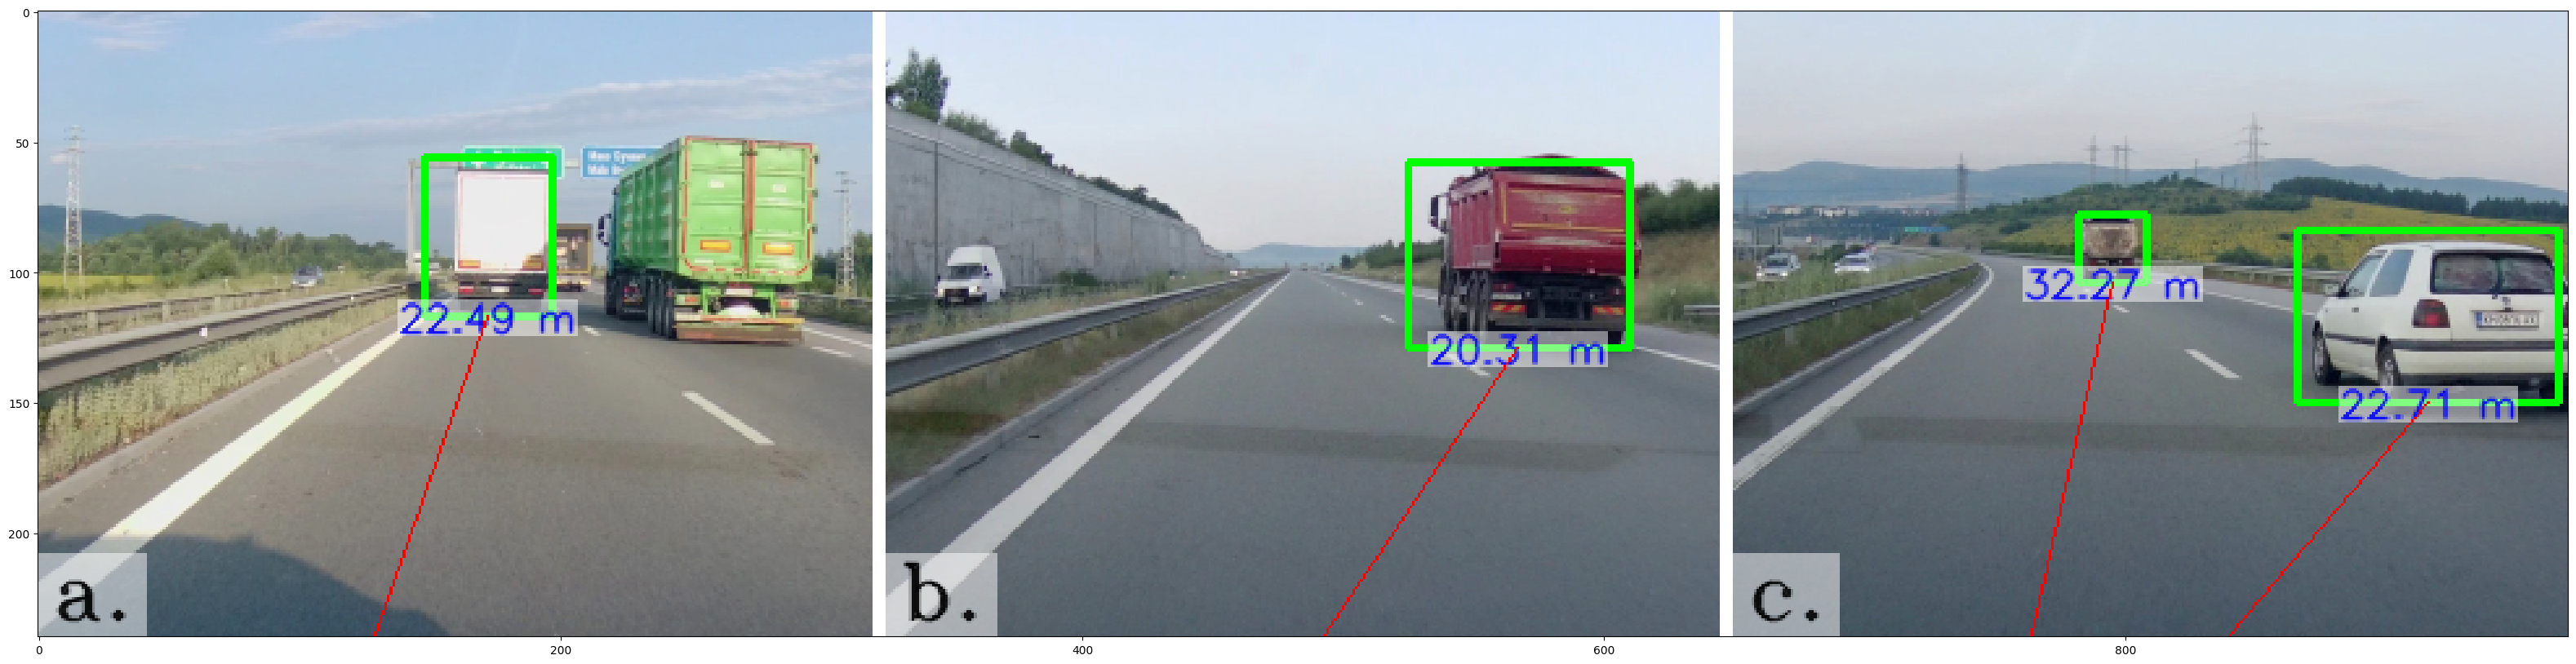

In [11]:
net = cv2.dnn.readNetFromTensorflow('../mask_rcnn_inception_v2_coco_2018_01_28.pb', '../mask_rcnn_inception_v2_coco_2018_01_28.pbtxt')

images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

for k in range(1, len(IMAGES)):
    start = time.time()
    
    img1 = x_test[k, ].copy()
    img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    normalized = cv2.resize(img1, (320, 240))

    # Prepare the depth image for inference
    blob = cv2.dnn.blobFromImage(normalized, swapRB=True, crop=False)
    net.setInput(blob)
    
    # Perform object detection
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])
    
    points = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    
    # Iterate through the detected objects
    for i in range(boxes.shape[2]):
        confidence = boxes[0, 0, i, 2]
        if confidence > 0.5:  # Filter out weak detections
            class_id = int(boxes[0, 0, i, 1])
            
            if class_id != 0:  # We only consider non-background classes
                # Extract the bounding box coordinates
                box = boxes[0, 0, i, 3:7] * np.array([320, 240, 320, 240])
                x1, y1, x2, y2 = box.astype(int)
                w = x2 - x1
                h = y2 - y1
                
                # Extract the depth values from the bounding box region
                # depth_values = normalized[y1:y2, x1:x2]
                
                # Compute the median depth value
                # median_depth = np.median(depth_values)
                
                # Print the coordinates of the bounding box and the median depth value
                # print(f"Object at ({x1}, {y1}) with width {w}, height {h} and median depth {median_depth}")
    
                points[y1 + h, x1 + w // 2] = 255
                # print(y1 + h, x1 + w // 2)
                
                # Optionally, you can draw the bounding box on the original depth image
                cv2.rectangle(normalized, (x1, y1), (x2, y2), (0, 255, 0), 2)
    print(f"Image {k} processing time: {int((time.time() - start) * 1000)} ms")
    
    image = cv2.cvtColor(normalized, cv2.COLOR_RGB2BGR)
    image =  draw_distances(image, predictions[k], points)
    # Display the results
    # plt.figure(k)
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    images[k,] = image

fig = (np.ones((HEIGHT, WIDTH * 3 + 2 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[1]
fig[:HEIGHT, WIDTH + MARGIN:2 * WIDTH + MARGIN] = images[2]
fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN:] = images[3]

labels = [("a.", 0, HEIGHT - 1),
          ("b.", WIDTH + MARGIN, HEIGHT - 1),
          ("c.", 2 * WIDTH + 2 * MARGIN, HEIGHT - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig7.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))